<div style="background-color:#00000">
    <img src="https://fundacionsadosky.org.ar/wp-content/uploads/2022/08/logo.png" />
</div>
<div style="background-color:#03030a; margin:20px 40%">
    <img src="https://www.rfindustrial.com/wp-content/uploads/2023/04/cropped-1080x1080_Mesa-de-trabajo-1.png" />
</div>
<div style="background-color:#00000;">
    <img src="https://sinc.unl.edu.ar/wp-content/themes/sinci/img/sinc-logo.png" />
</div>

<p style="font-size: 30px">
    <strong>COPE - “Sistema inteligente de medición de nivel y control de velocidad de bombeo para pozos petrolíferos"</strong>
</p>

<p style="font-size: 20px">
    Objetivo del análisis: Realizar un primer acercamiento a los datos para comprender su estructura, valores comúnes, características principales de las señales, entre otros.
</p>

21/03/2023

# Imports generales

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import struct
import matplotlib.pyplot as plt
from ipywidgets import interact_manual, widgets

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Exploración de archivos para uno de los equipos

In [2]:
!tree ../data/raw/ecometrias/1

/Library/Developer/CommandLineTools/usr/bin/python3: No module named virtualfish
../data/raw/ecometrias/1
├── Cont
├── Program.json
├── ProgramCouter
├── _10_23_02_15_24__Frec1(301)_IncF(40)_Nciclos(5)_SwIn(1)_Down(32)_Nsamp)16000)
│   ├── _Eco_02_15_24.json
│   ├── _Eco_02_20_53.json
│   ├── _Eco_02_34_25.json
│   ├── _Eco_02_42_17.json
│   ├── _Eco_02_48_12.json
│   └── _Eco_02_52_23.json
├── _10_23_19_19_57__Frec1(400)_IncF(50)_Nciclos(5)_SwIn(1)_Down(32)_Nsamp)16000)
│   ├── _Eco_19_19_57.json
│   ├── _Eco_19_20_51.json
│   └── _Eco_19_27_12.json
├── _10_23_19_51_27__Frec1(400)_IncF(50)_Nciclos(5)_SwIn(1)_Down(32)_Nsamp)16000)
│   └── _Eco_19_51_27.json
├── _10_23_19_55_26__Frec1(400)_IncF(50)_Nciclos(5)_SwIn(1)_Down(32)_Nsamp)16000)
│   └── _Eco_19_55_26.json
├── _10_24_00_17_50__Frec1(300)_IncF(150)_Nciclos(3)_SwIn(1)_Down(32)_Nsamp)16000)
│   └── _Eco_00_17_50.json
├── _10_24_00_20_09__Frec1(300)_IncF(150)_Nciclos(3)_SwIn(1)_Down(32)_Nsamp)16000)
│   ├── _Eco_00_17_50.json
│   ├

# Definición de funciones útiles

In [3]:
def load_sample_file(sample_full_path):
    df = pd.read_json(sample_full_path, typ='series')
    
    final_values = []
    
    data_values = df.datos
    data_values = data_values.strip("[]").split(",")
    
    for value in data_values:
        # Convierte el valor hexadecimal a un entero sin signo de 32 bits
        value = int(value, 16) & 0xFFFFFFFF
        
        # Verifica si el bit más significativo es 1 para determinar si el valor está en complemento a uno
        if value & 0x80000000:
            # Si el bit más significativo es 1, convierte el valor a su complemento a dos
            value = -(0x100000000 - value)

        # Agrega el valor a la lista de enteros
        final_values.append(value)
    
    return df, final_values

In [4]:
def get_input_signal(initial_freq, signal_step, freq_step, n_cycles):
    with open('tabla_seno.bin', 'rb') as file:
        bytes = file.read()
        sine_values = struct.unpack('{}H'.format(len(bytes) // 2), bytes)
    
    # Se crea una lista vacía que se llenará con los valores de la señal muestreada
    signal_values = []
    cycles_info = []

    # Se inicializan las variables de iteración
    inter = 0
    freq = initial_freq
    step = signal_step // 32
    
    last_cycle_inter = 0
    
    # Se ejecuta un ciclo para generar la señal senoidal
    for i in range(n_cycles):
        j = 0
        # Se recorre la tabla de valores precalculados de la función seno
        while j < len(sine_values):
            # Se verifica si se debe tomar una muestra en este punto
            if inter % step == 0:
                # Se obtiene el valor de la función seno en este punto
                y = sine_values[j]
                # Se agrega el valor de la muestra a la lista
                signal_values.append(y)
            # Se avanza al siguiente punto de la señal
            j += freq
            # Se incrementa el índice que se utiliza para verificar si se debe tomar una muestra
            inter += 1
        # Se recorre la tabla de valores precalculados de la función seno en sentido inverso
        while j < 2 * len(sine_values):
            # Se verifica si se debe tomar una muestra en este punto
            if inter % step == 0:
                # Se obtiene el valor de la función seno en este punto y se invierte su signo
                y = -sine_values[j - len(sine_values)]
                # Se agrega el valor de la muestra a la lista
                signal_values.append(y)
            # Se avanza al siguiente punto de la señal
            j += freq
            # Se incrementa el índice que se utiliza para verificar si se debe tomar una muestra
            inter += 1
        # Se ajusta el índice para reiniciar la generación de la señal en la tabla de valores
        j -= 2 * len(sine_values)
        
        cycles_info.append((inter - last_cycle_inter, freq))
        last_cycle_inter = inter
    
                           
        # Se incrementa la frecuencia de la señal para el siguiente ciclo
        freq += freq_step
    
    return signal_values, cycles_info

# Explicación de cómo se genera el pulso de entrada

A partir de una lista de números (la cual se grafica a continuación), lo que se hace por cada ciclo es ir leyendo los valores de dicho array incrementando la posición de lectura tantas posiciones como sea la frecuencia inicial (por ejemplo 301). Por cada ciclo se leen los valores de forma incremental hasta tanto el índice llegue al final del array, y luego se comienza a leer nuevamente de adelante hacia atrás de la misma manera pero tomando el valor de lectura como negativo.

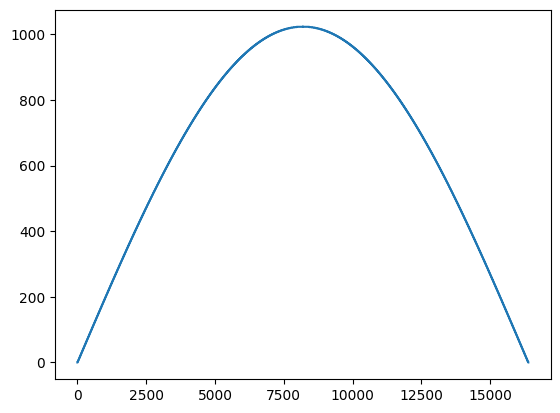

In [5]:
with open('tabla_seno.bin', 'rb') as file:
    bytes = file.read()
    sine_values = struct.unpack('{}H'.format(len(bytes) // 2), bytes)

t = list(range(len(sine_values)))
s = sine_values

plt.plot(t, s)

# Determinación del ejemplo a utilizar

In [6]:
id_equipo = 1
path = '_10_23_02_15_24__Frec1(301)_IncF(40)_Nciclos(5)_SwIn(1)_Down(32)_Nsamp)16000)'
file = '_Eco_02_15_24.json'
full_path = f'../data/raw/ecometrias/{id_equipo}/{path}/{file}'

df, final_values = load_sample_file(full_path)

df

Id                                                         1
Frec1                                                    301
IncF                                                      40
Nciclos                                                    5
Aten                                                       0
SwIn                                                       1
Filter                                                     5
Down                                                      32
Dummy                                                      0
Nsamp                                                  16000
datos      [2CCBE557,4330934A,E726BD8A,E5DF3ED3,E48A54BC,...
dtype: object

In [7]:
signal_values, cycles_info = get_input_signal(df.Frec1, df.Down, df.IncF, df.Nciclos)

In [8]:
x_values = []
last_cycle_value = 0
for n_cycle in range(5):
    x_values += list(np.linspace(last_cycle_value, last_cycle_value + 1 / cycles_info[n_cycle][1], cycles_info[n_cycle][0]))
    last_cycle_value = x_values[-1] + (x_values[-1] - x_values[-2])

## Visualización del pulso de entrada

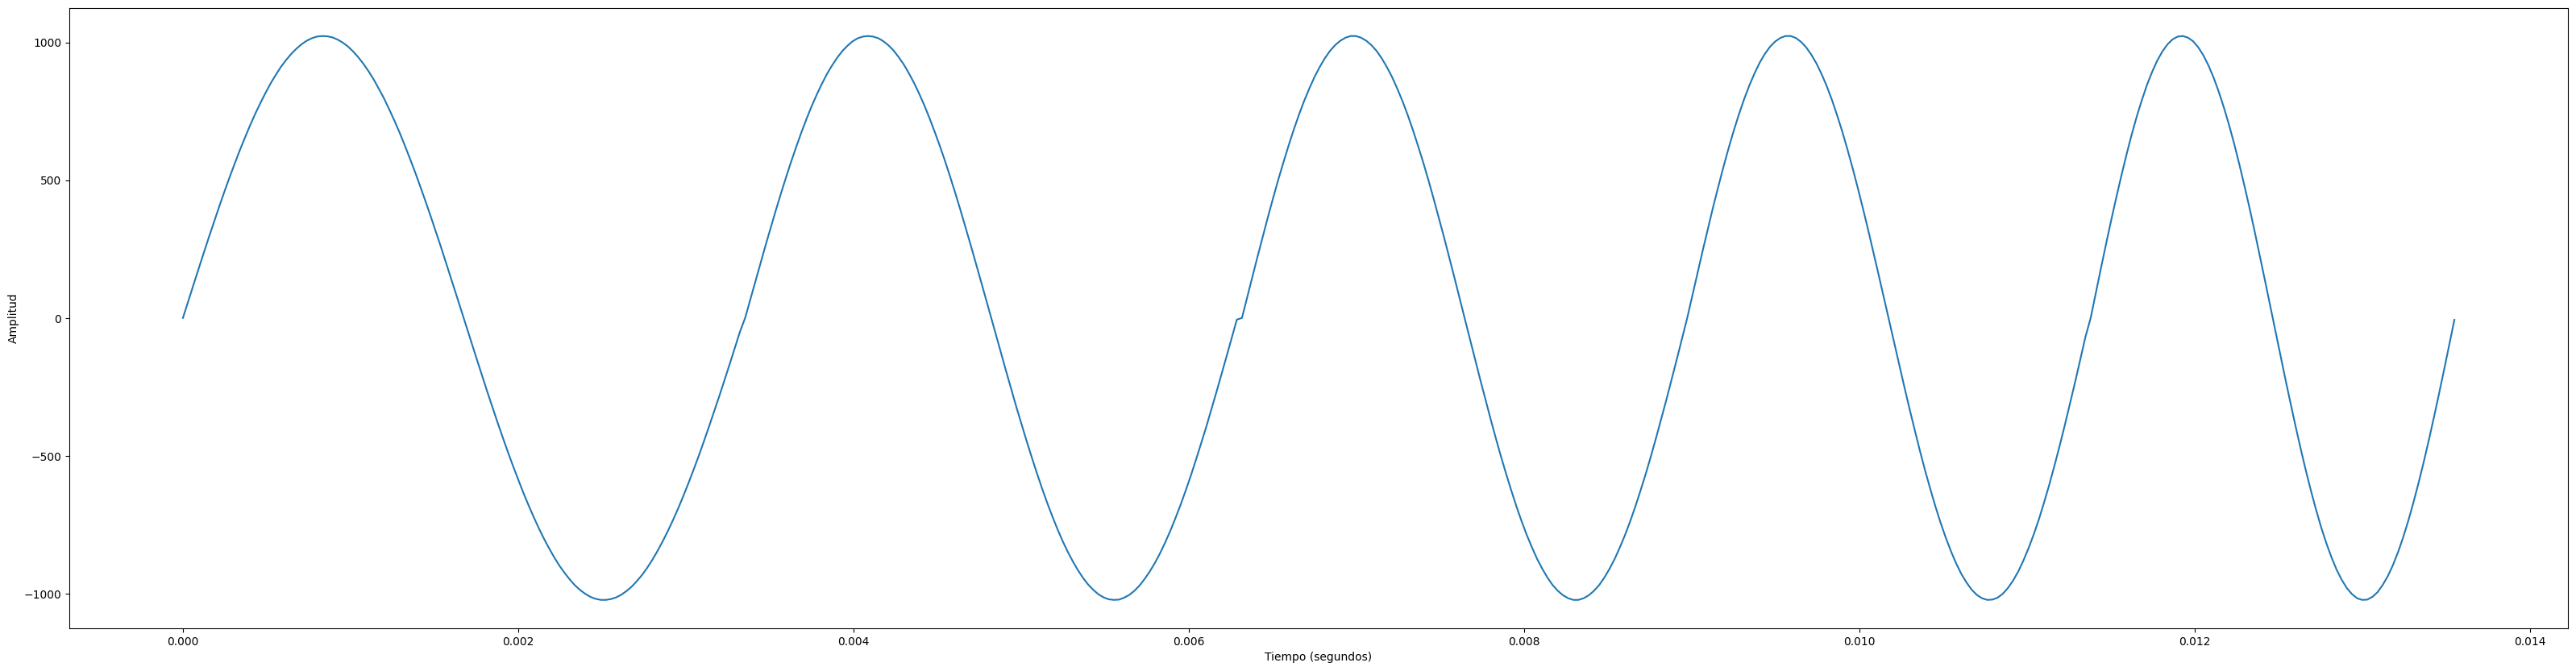

In [9]:
# Graficar señal
fig, ax = plt.subplots(figsize=(40, 10))
ax.plot(x_values, signal_values) # agregar datos a la gráfica
#ax.set_xlim([0, len(signal_values)]) # establecer límites del eje x
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')
plt.show()

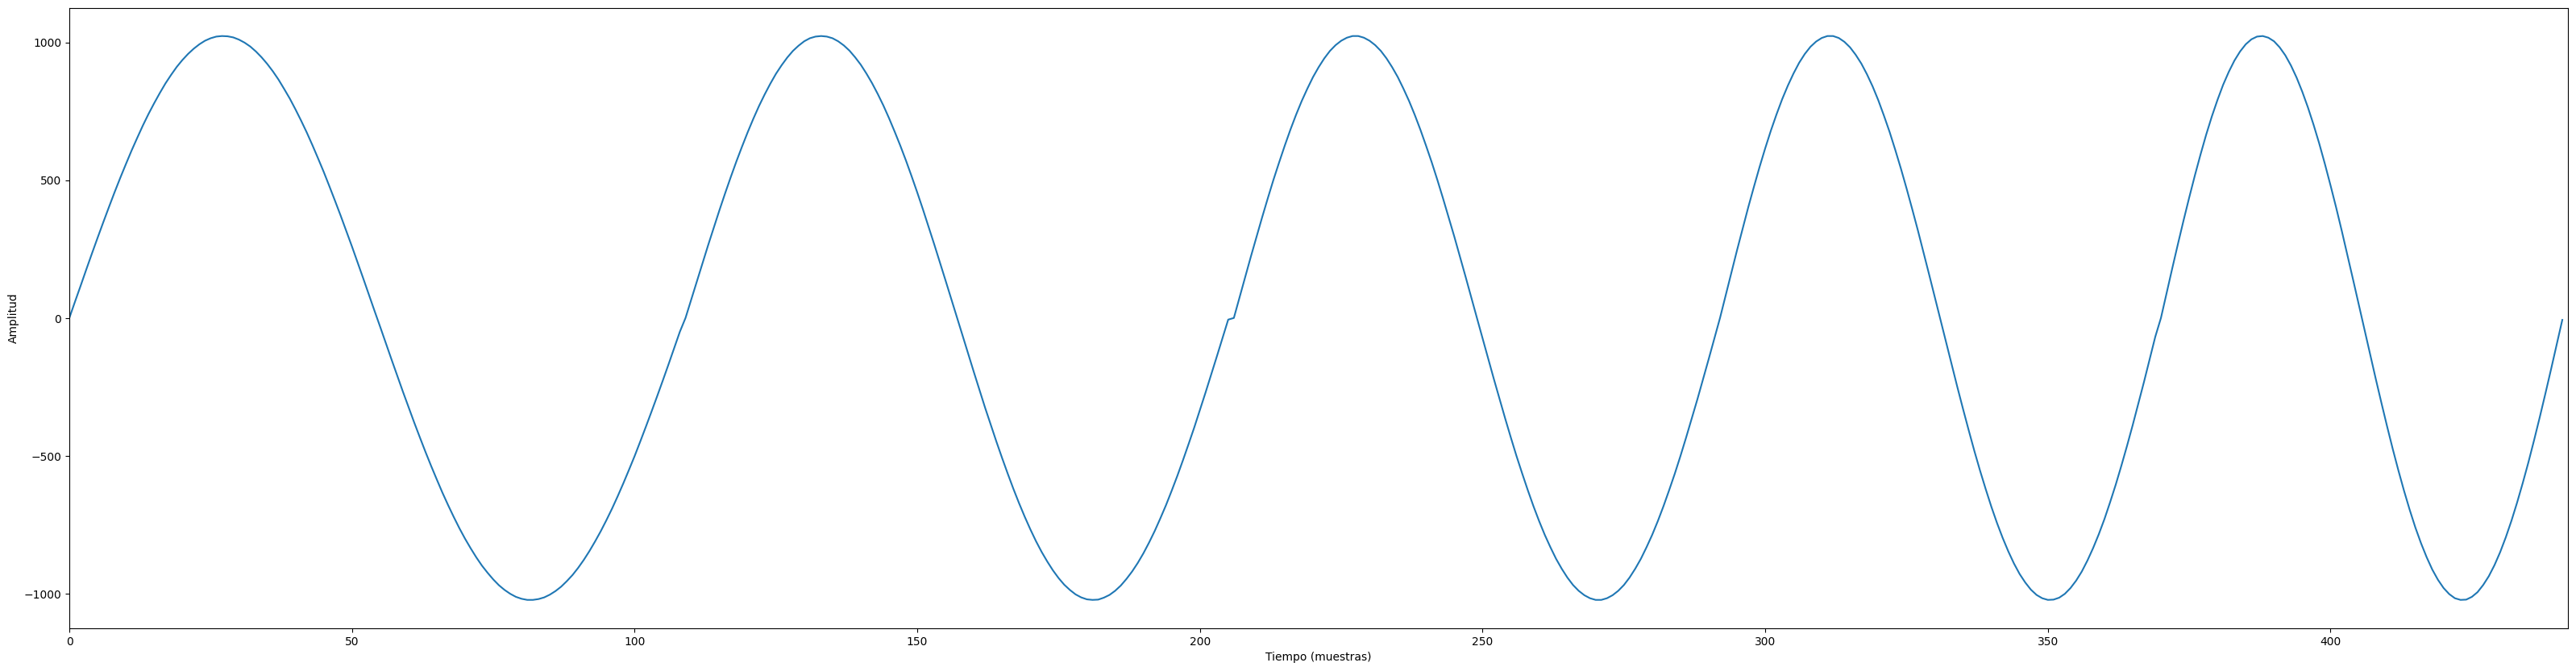

In [10]:
# Graficar señal
fig, ax = plt.subplots(figsize=(40, 10))
ax.plot(signal_values) # agregar datos a la gráfica
ax.set_xlim([0, len(signal_values)]) # establecer límites del eje x
plt.xlabel('Tiempo (muestras)')
plt.ylabel('Amplitud')
plt.show()

## Visualización de señal de salida

In [11]:
final_signal_freq = 930000 / df.Down
x_values = np.linspace(0, len(final_values) / final_signal_freq, len(final_values))

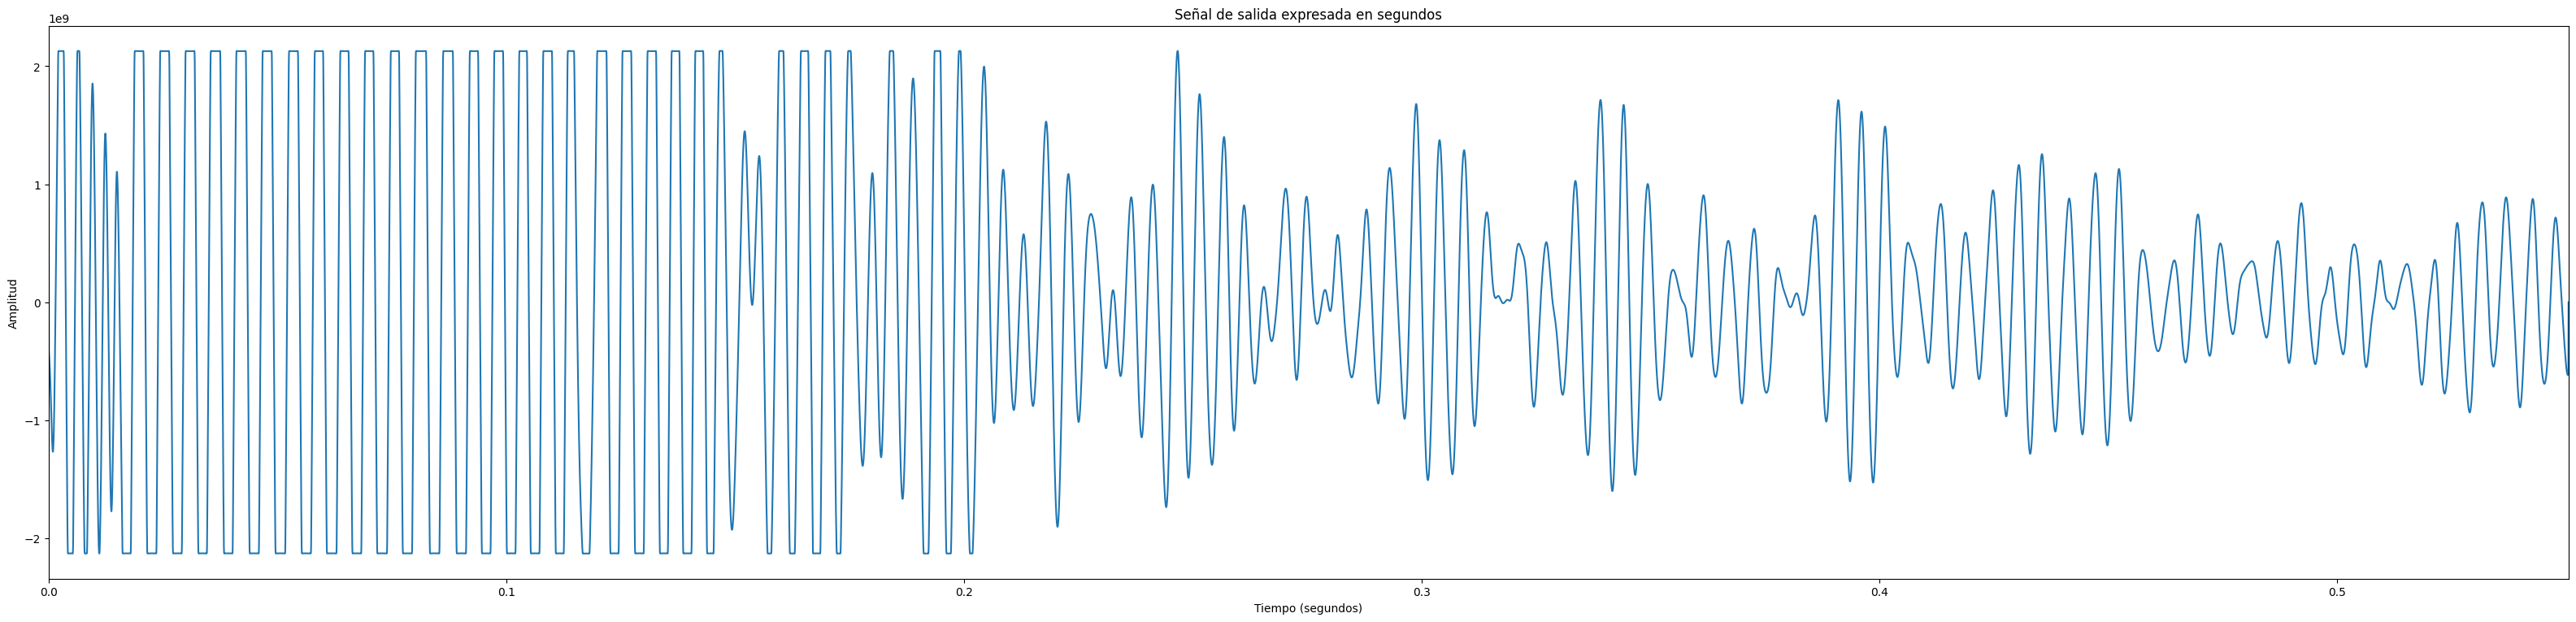

In [12]:
# Graficar señal
fig, ax = plt.subplots(figsize=(40, 10))
fig.subplots_adjust(bottom=0.2)
ax.set_xlim([0, x_values[-1]]) # establecer límites del eje x
ax.plot(x_values, final_values) # agregar datos a la gráfica
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')
plt.title('Señal de salida expresada en segundos')
plt.show()

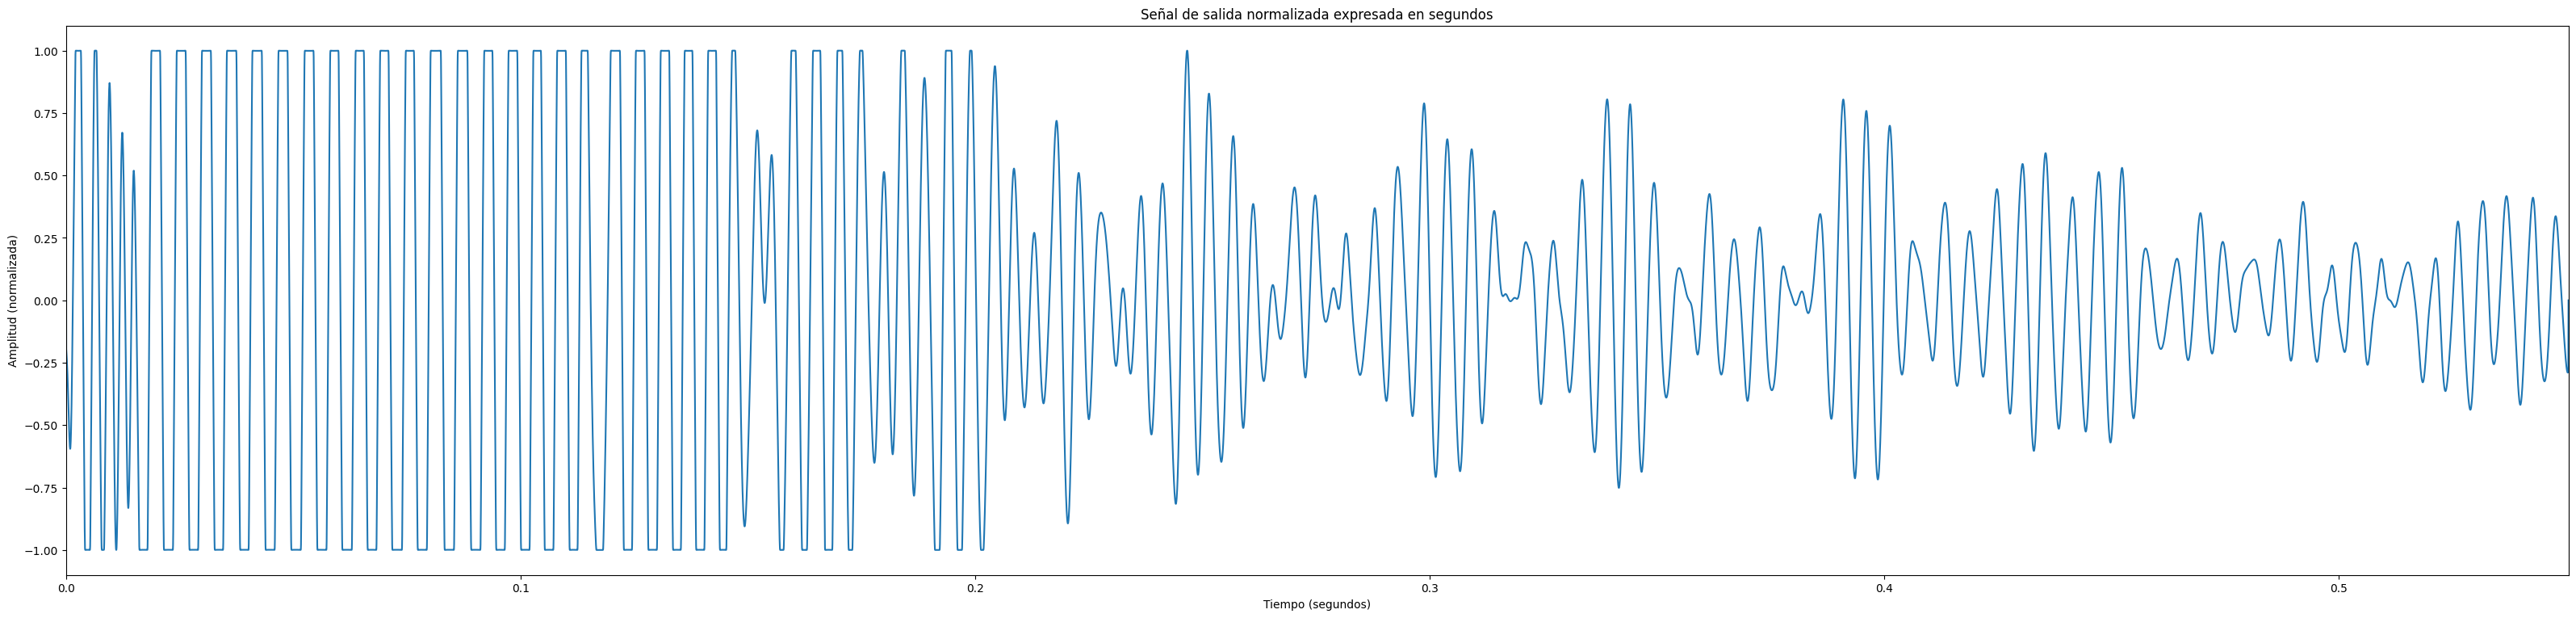

In [13]:
# Graficar señal
fig, ax = plt.subplots(figsize=(40, 10))
fig.subplots_adjust(bottom=0.2)
ax.set_xlim([0, x_values[-1]]) # establecer límites del eje x
final_values_norm = final_values / np.max(np.abs(final_values))
ax.plot(x_values, final_values_norm) # agregar datos a la gráfica
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud (normalizada)')
plt.title('Señal de salida normalizada expresada en segundos')
plt.show()

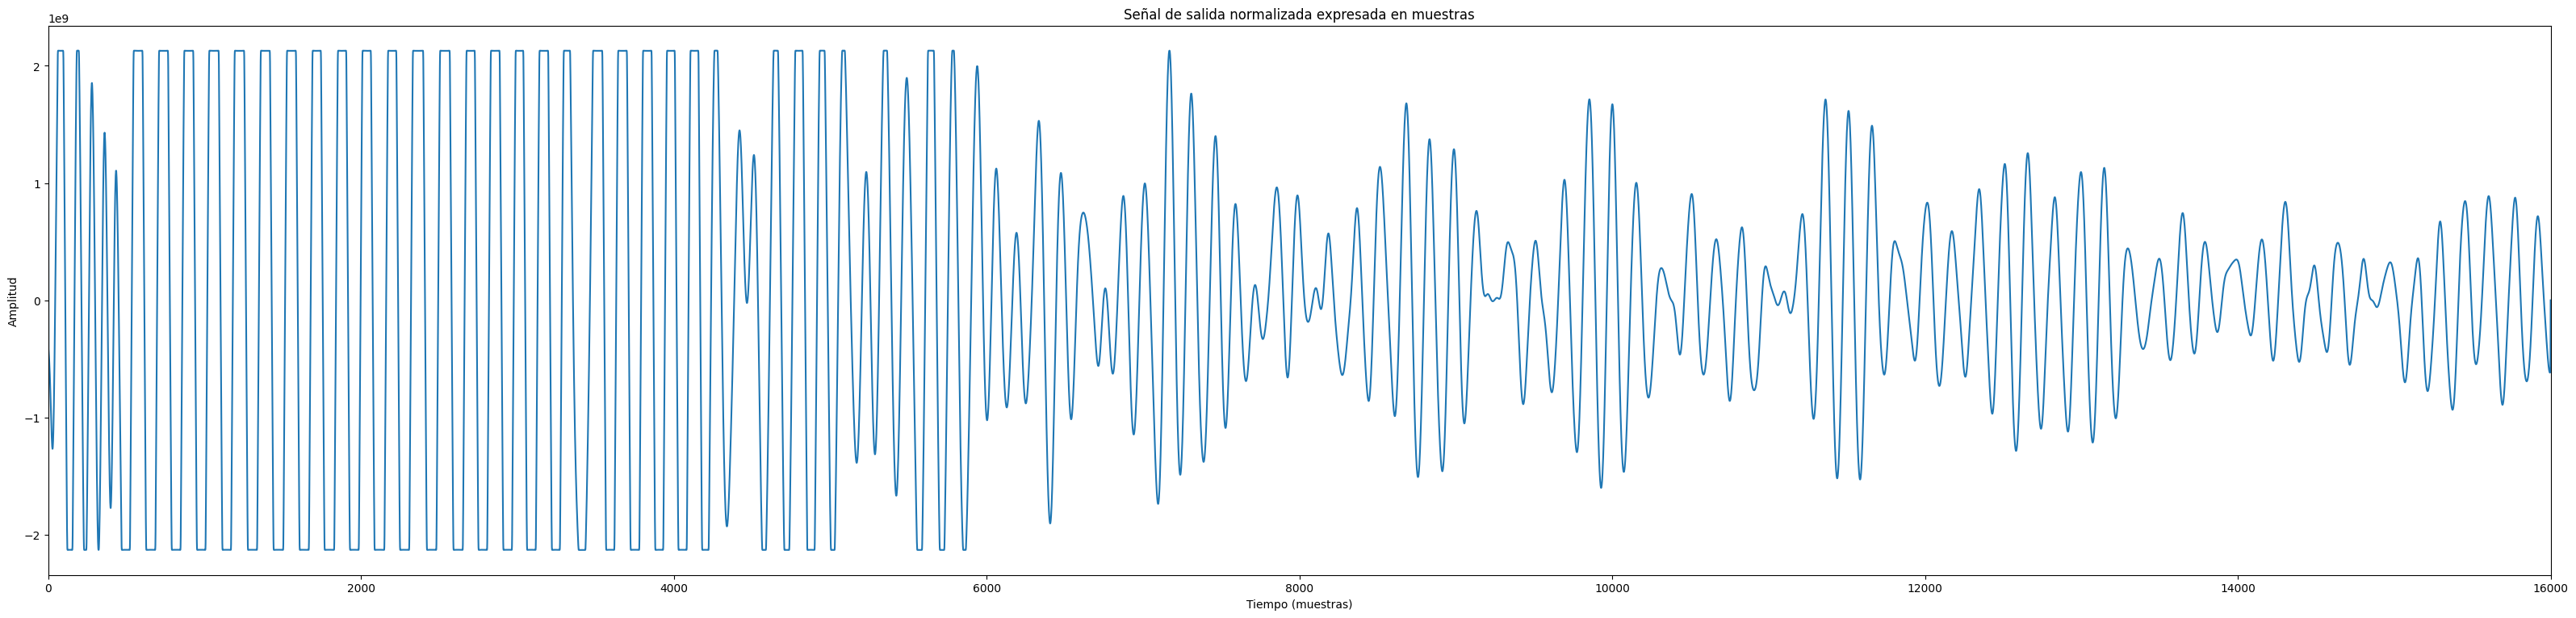

In [14]:
# Graficar señal
fig, ax = plt.subplots(figsize=(40, 10))
fig.subplots_adjust(bottom=0.2)
ax.set_xlim([0, len(final_values)]) # establecer límites del eje x
ax.plot(final_values) # agregar datos a la gráfica
plt.xlabel('Tiempo (muestras)')
plt.ylabel('Amplitud')
plt.title('Señal de salida normalizada expresada en muestras')
plt.show()

## Visualización de un espectrograma para un tamaño de ventana y solapamiento determinado

In [15]:
# distancia entre cuplas estimada: 9.6 m
# distancia necesaria de recorrido del disparo: 19.2 m
# velocidad promedio del sonido en el medio: 343 m/s
# tiempo aproximado de llegada del eco en la primera cupla: 19.2 / 343 = 0,05598 s

In [16]:
final_signal_freq

29062.5

In [17]:
0.025 / (1 / 29062.5)

726.5625

In [18]:
nfft_w = widgets.IntText(
    value=32,
    description='NFFT:',
    disabled=False
)

noverlap_w = widgets.IntText(
    value=8,
    description='No overlap:',
    disabled=False
)

@interact_manual(nfft=nfft_w, noverlap=noverlap_w)
def plot_specgram(nfft, noverlap):
    fig, ax = plt.subplots(figsize=(20, 10))
    Pxx, freqs, bins, im = ax.specgram(final_values_norm,
                                       NFFT=nfft,
                                       Fs=final_signal_freq,
                                       noverlap=noverlap,
                                       cmap=plt.get_cmap('plasma'))

    plt.axis([0, 0.1, 0, 2000])

    plt.xlabel('Tiempo (segundos)')
    plt.ylabel('Frecuencia (Hz)')
    
    plt.title(f'Espectrograma utilizando una ventana de {nfft} muestras y una superposición de {noverlap}.')
    plt.show()

interactive(children=(IntText(value=32, description='NFFT:'), IntText(value=8, description='No overlap:'), But…

In [19]:
#def plot_specgram(signal_values, nfft, noverlap, #ylim=[0, 7500]):
def plot_specgram(signal_values, nfft, noverlap):
    fig, ax = plt.subplots(figsize=(40, 20))
    Pxx, freqs, bins, im = ax.specgram(signal_values,
                                       NFFT=nfft,
                                       Fs=final_signal_freq,
                                       noverlap=noverlap)
    plt.axis([0, 0.2, 0, 1500])
    plt.title(f'Espectrograma utilizando una ventana de {nfft} muestras y una superposición de {noverlap}.')
#    plt.ylim(ylim)
    plt.show()

In [20]:
nfft_values = [2 ** i for i in range(3, 8)]

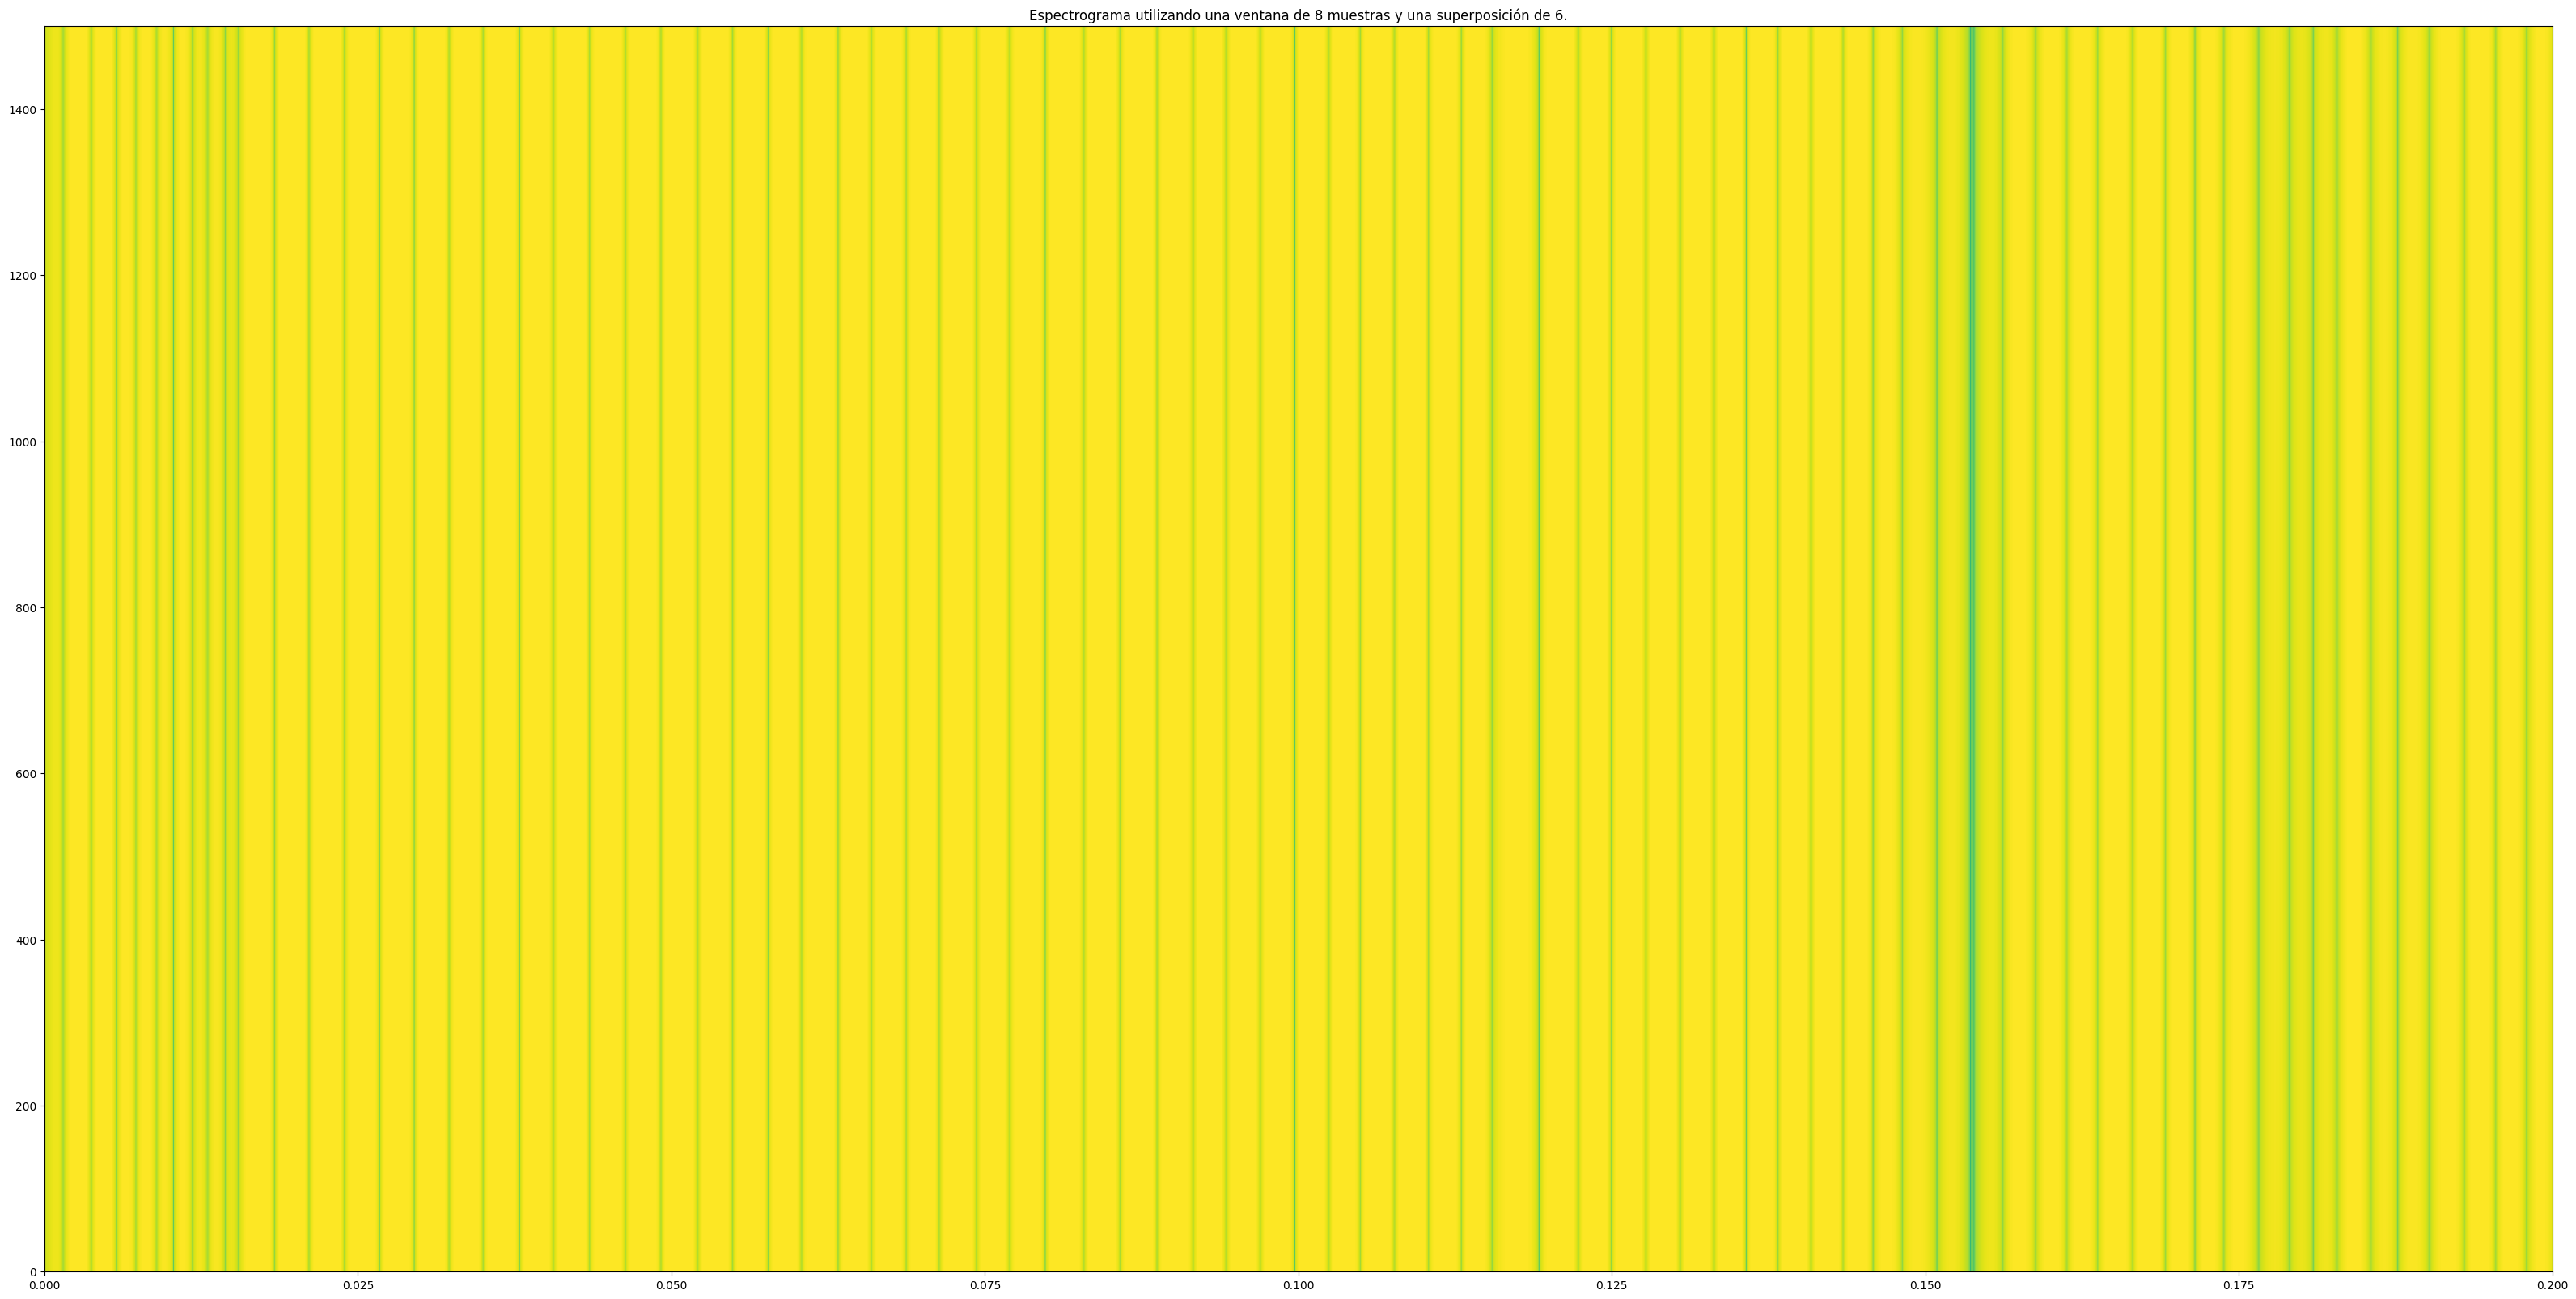

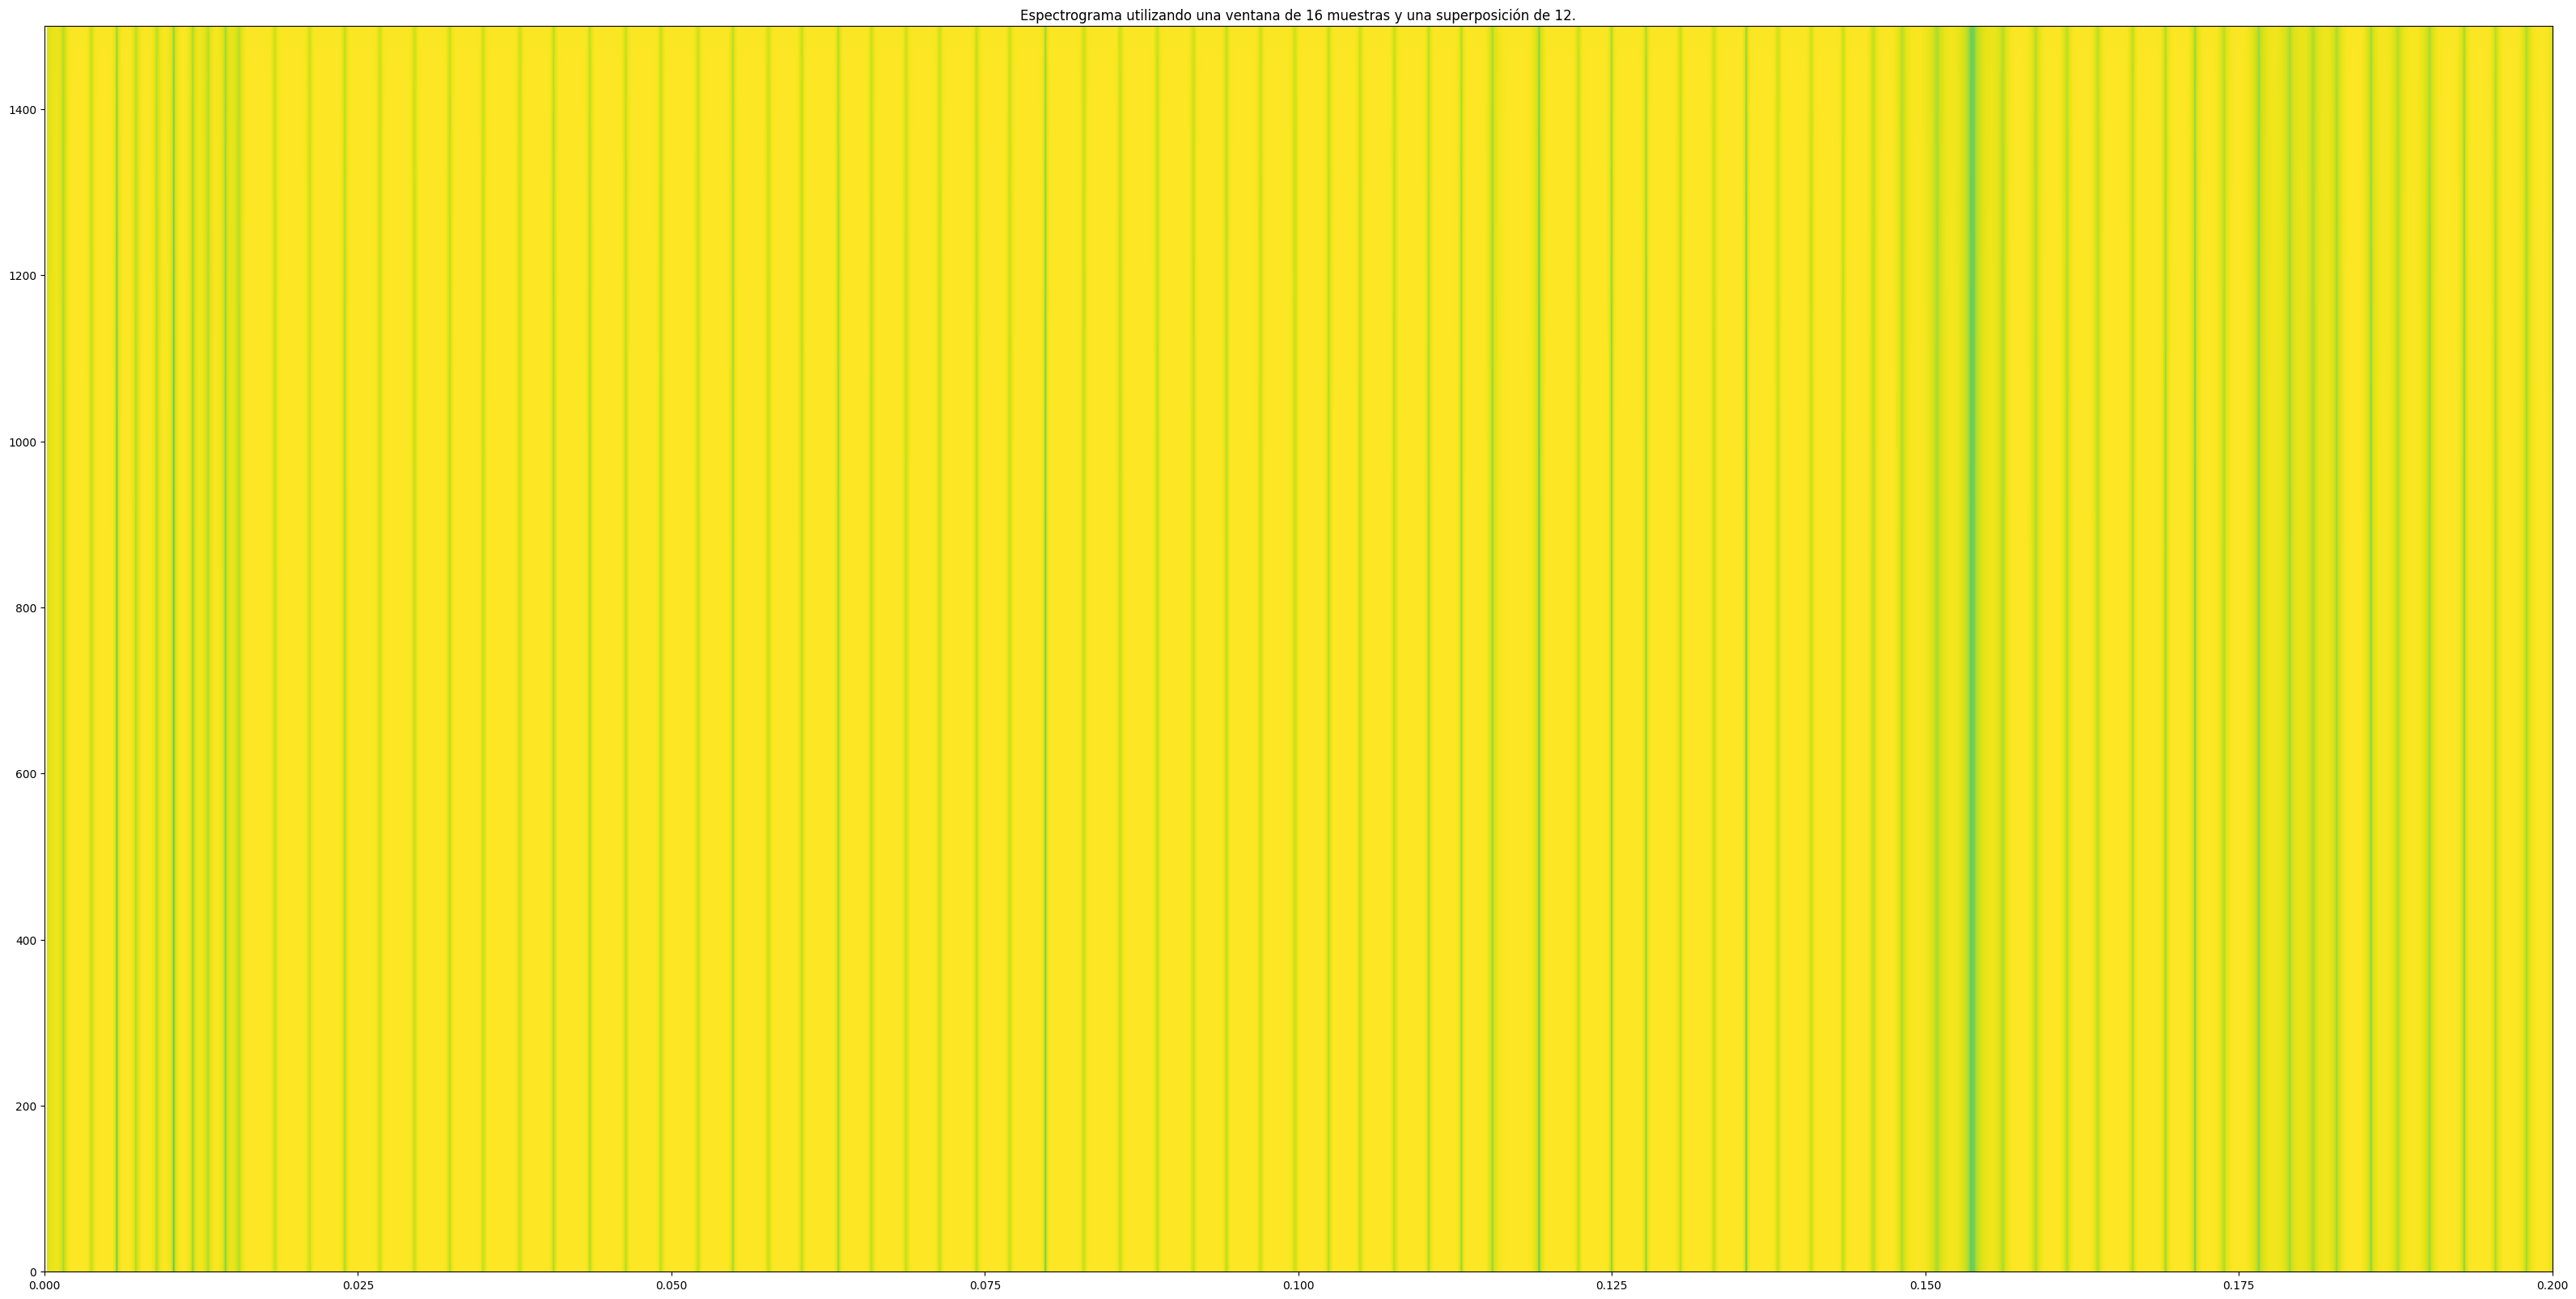

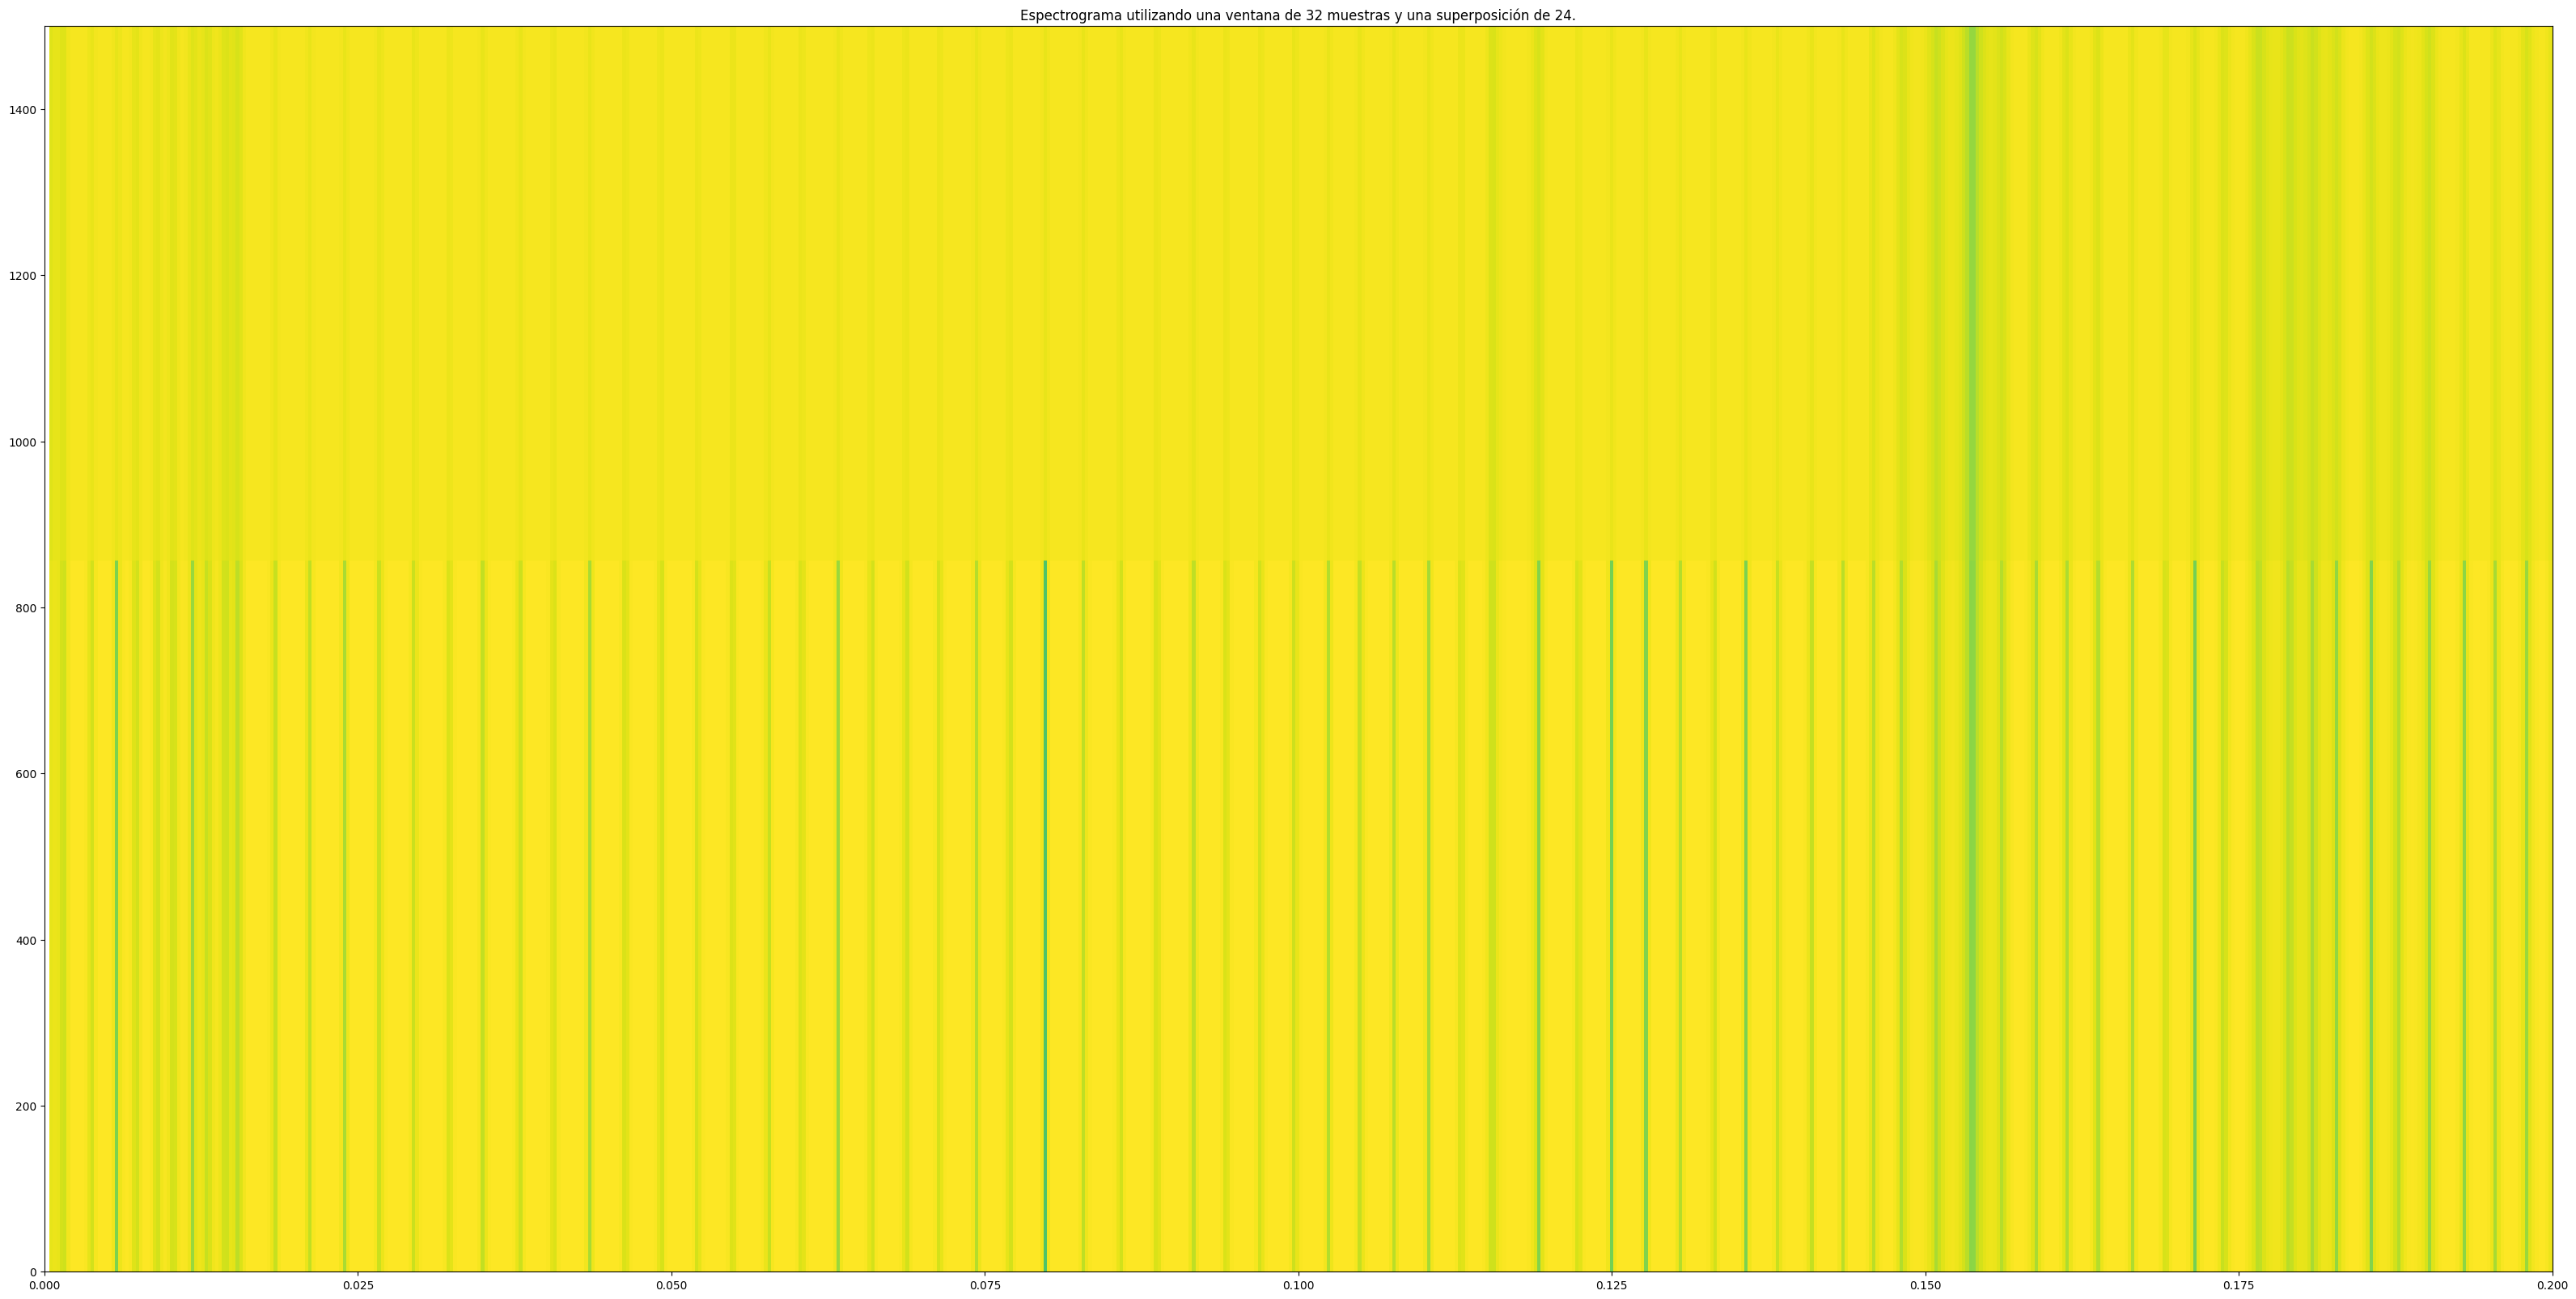

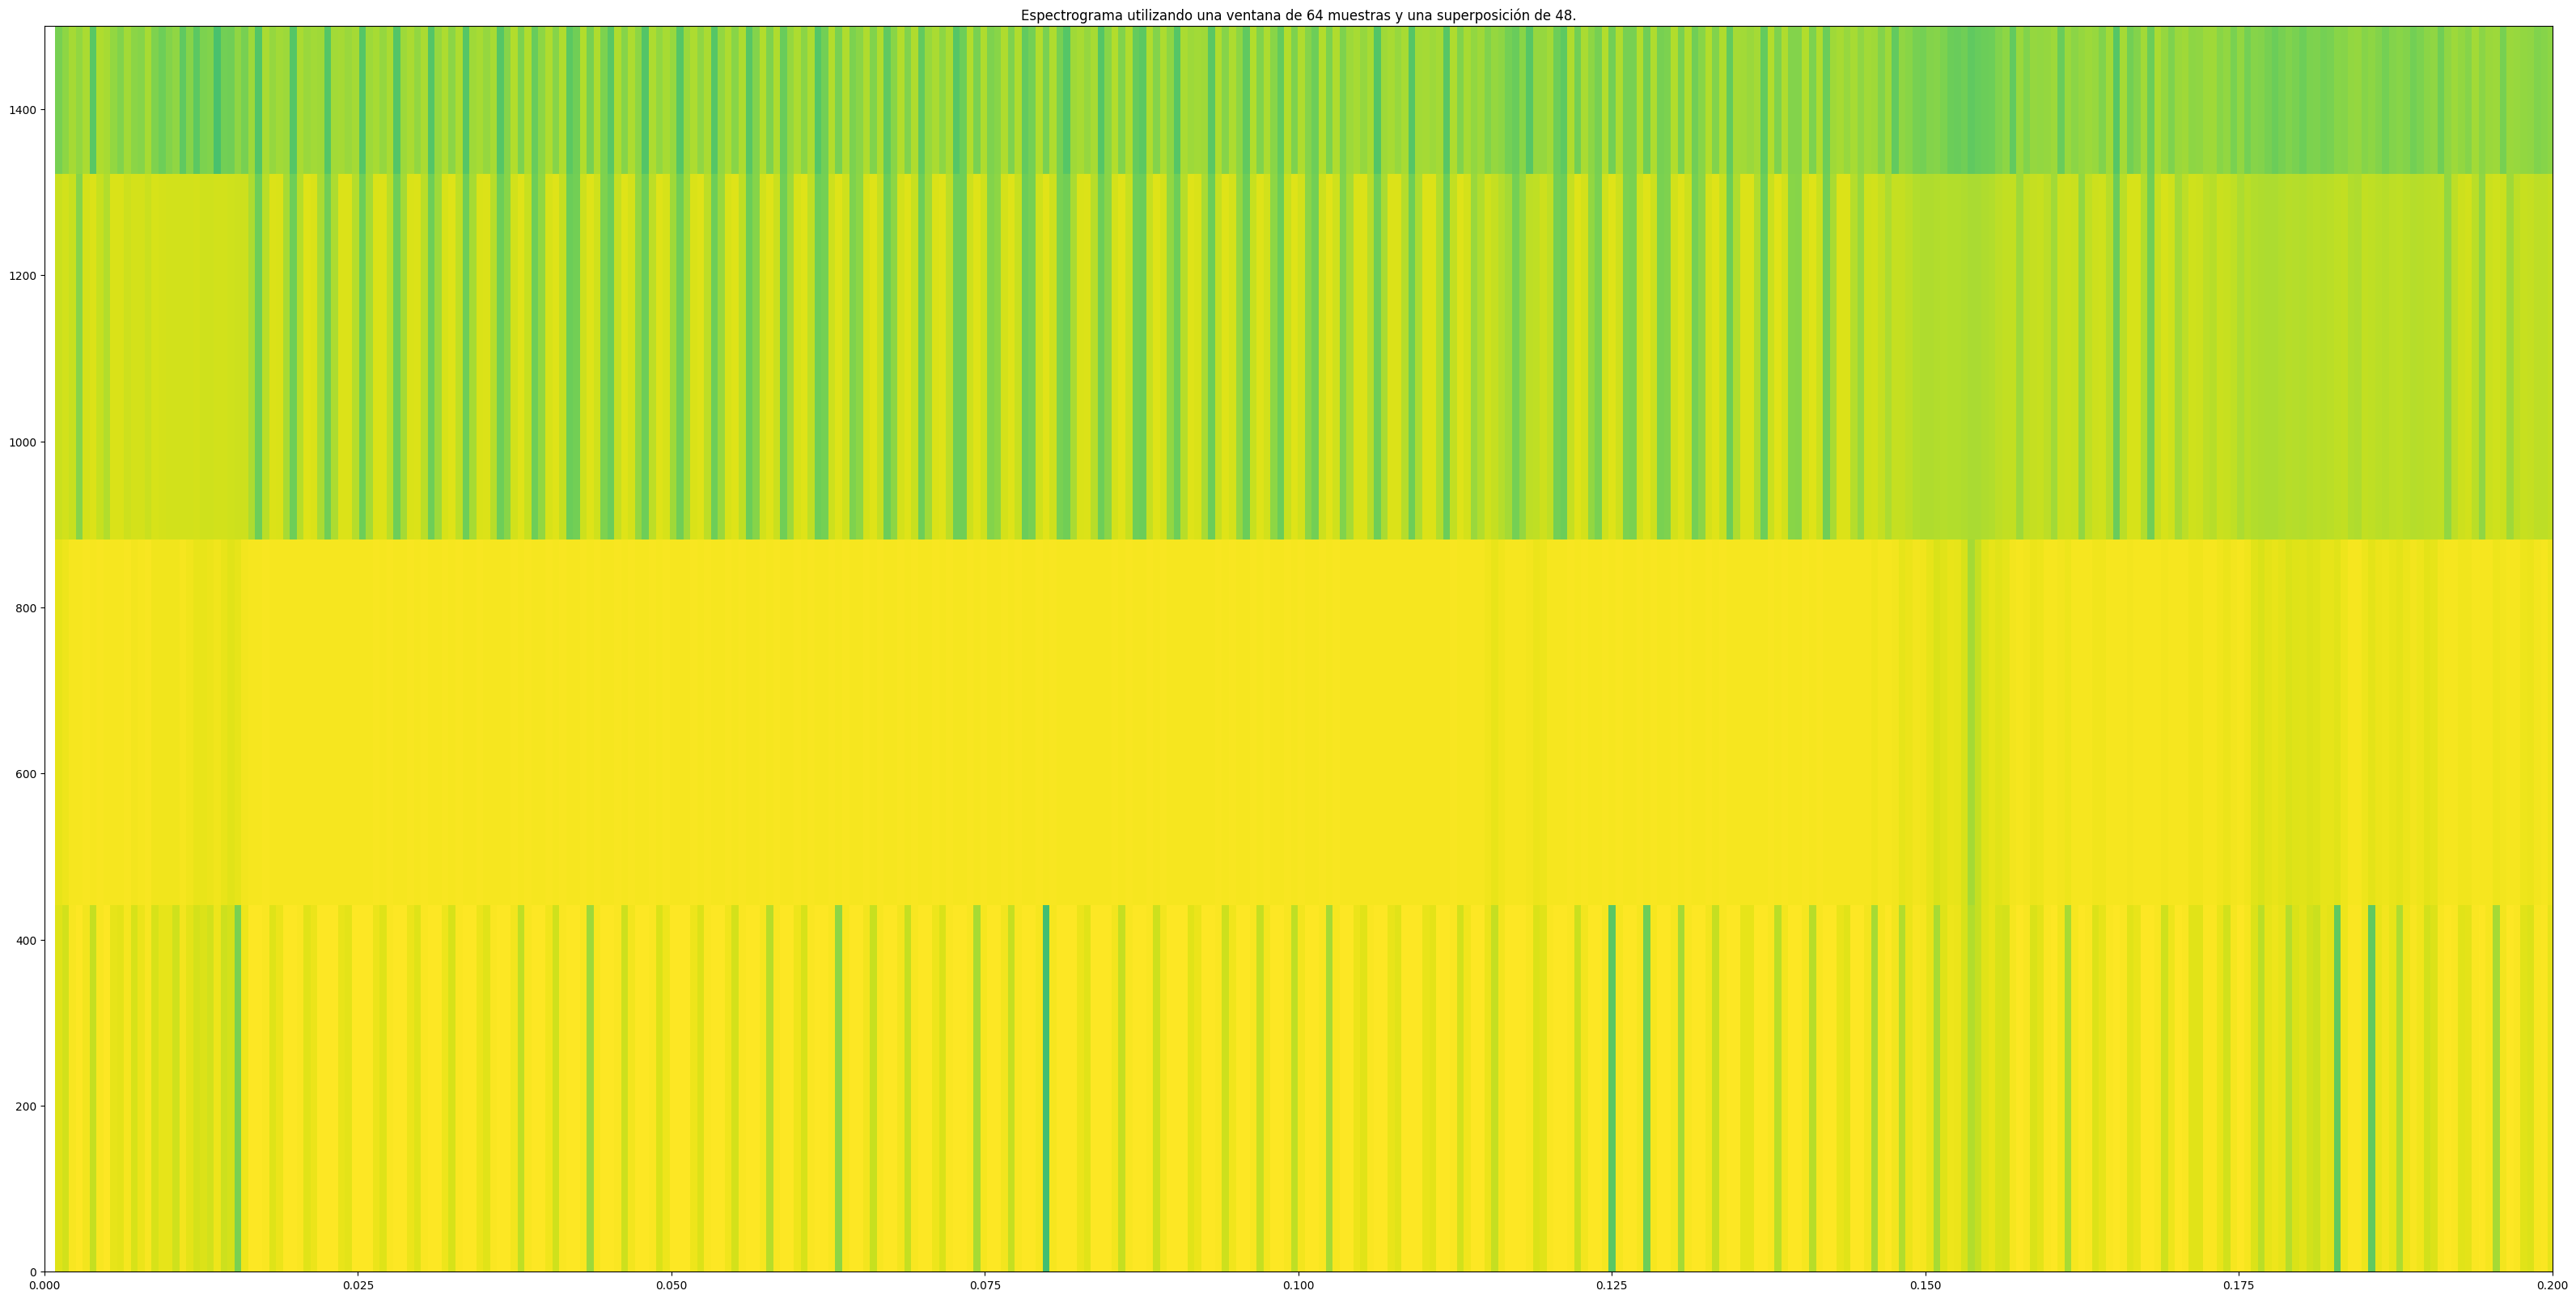

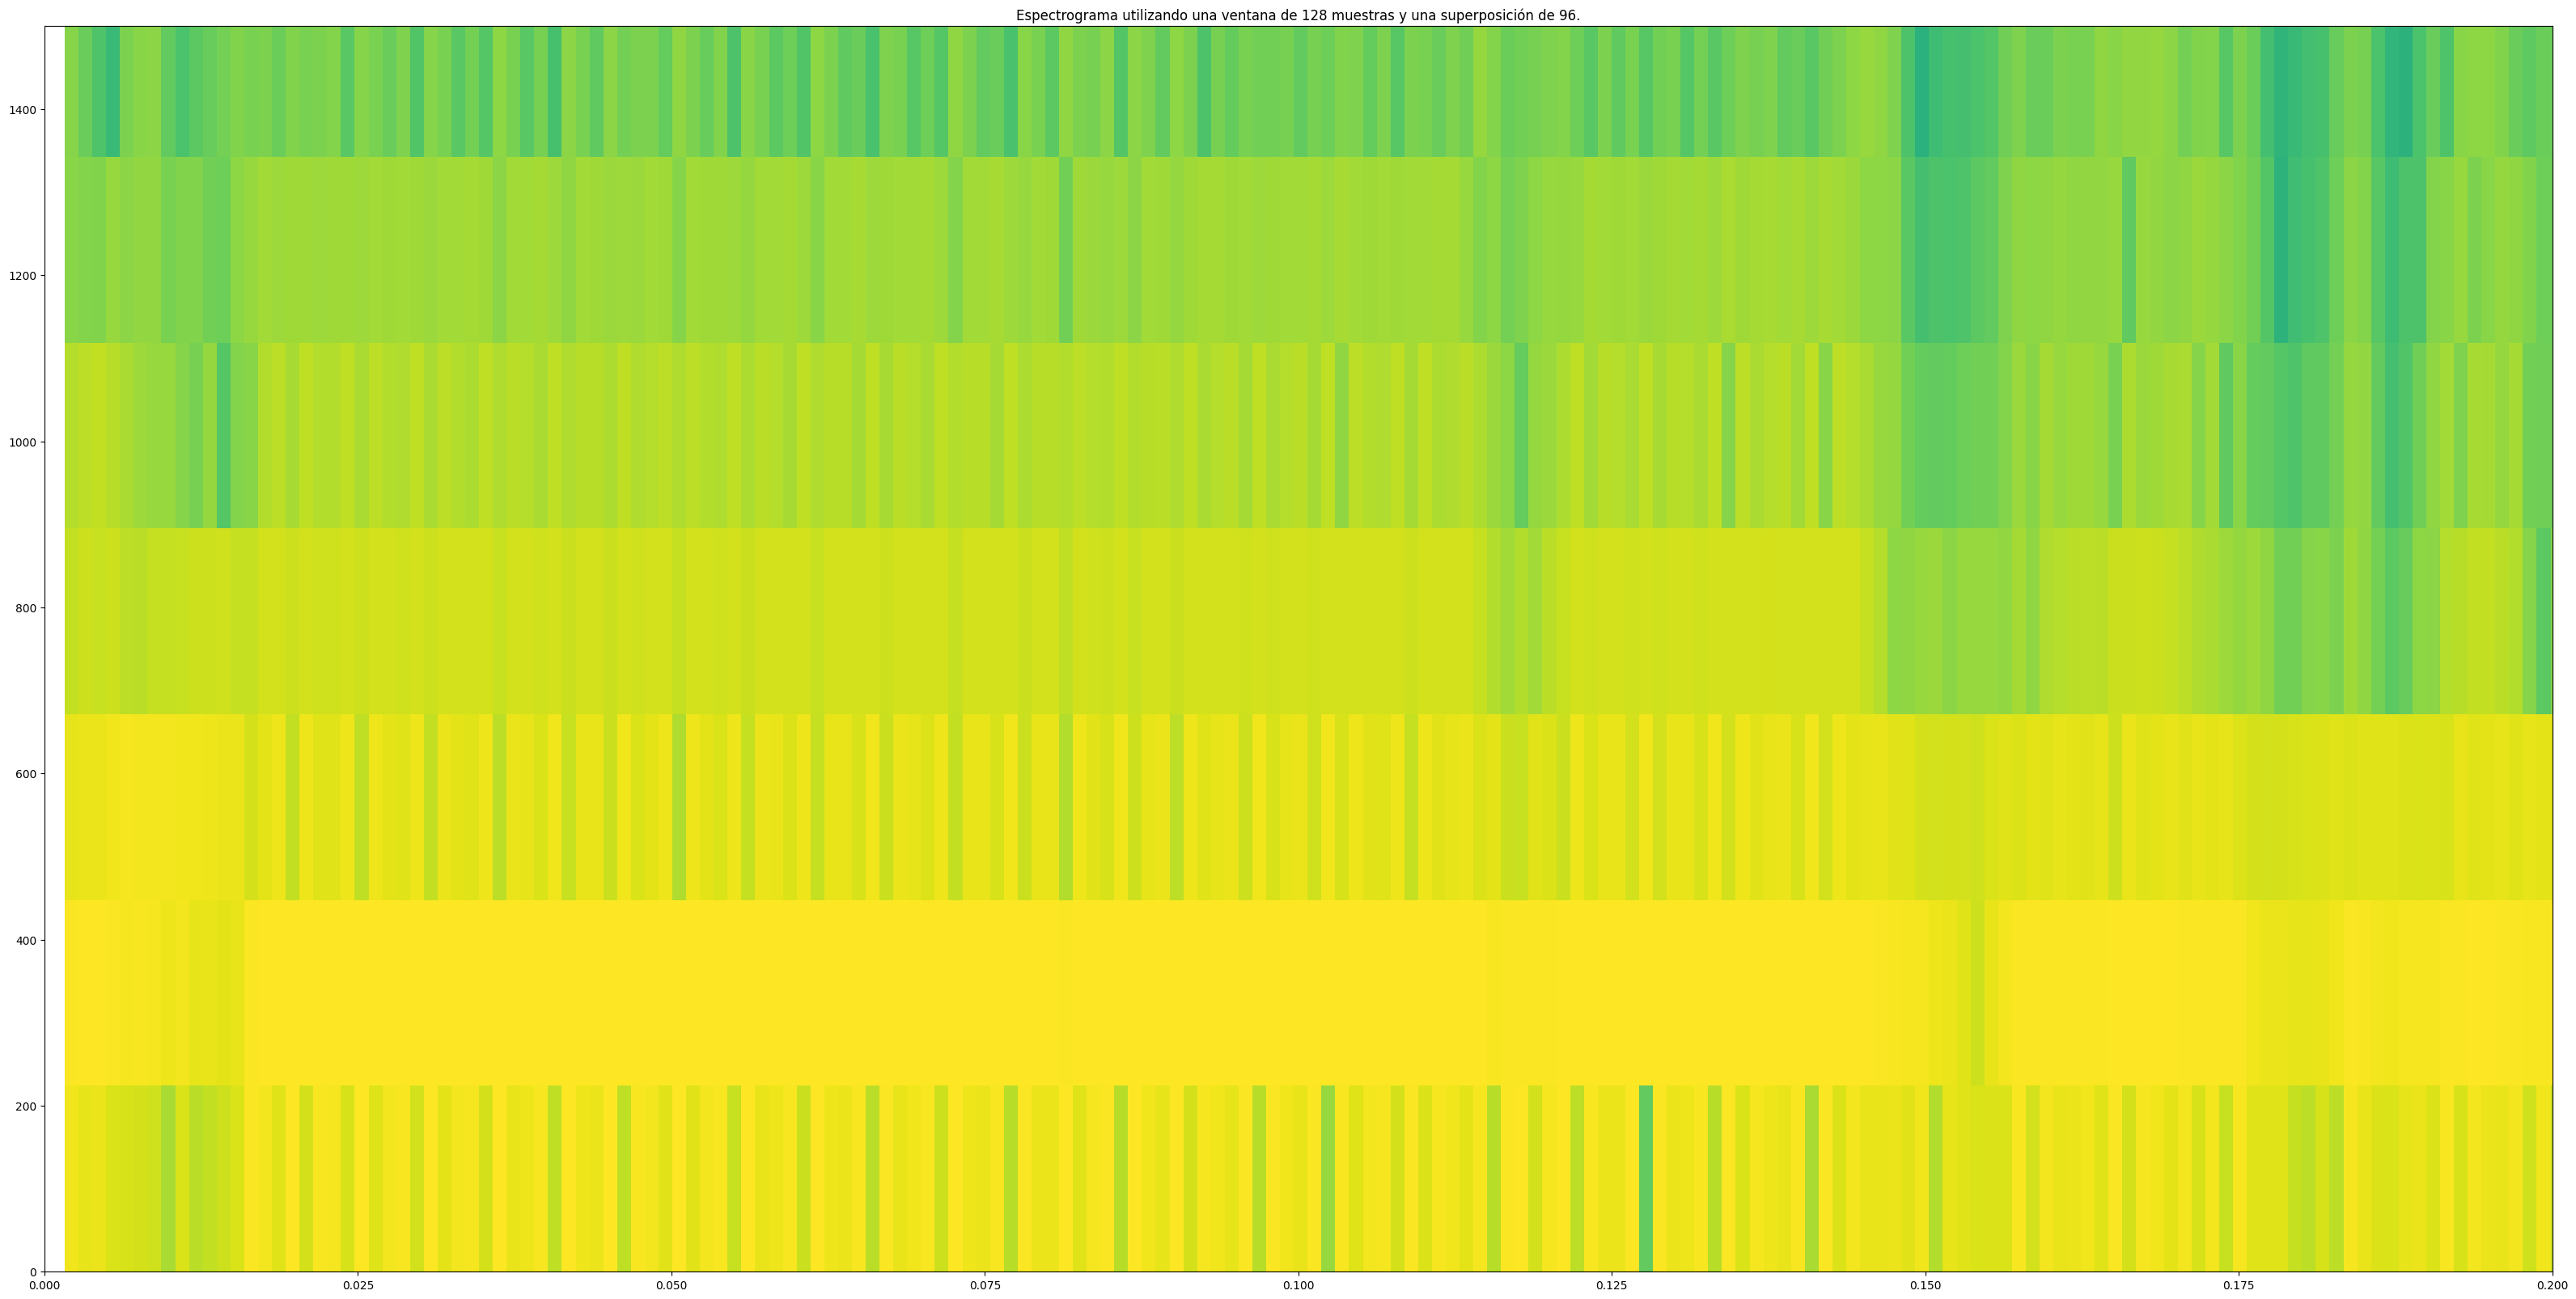

In [21]:
for nfft_v in nfft_values:
    plot_specgram(final_values_norm, nfft_v, int(nfft_v * 0.75))

# Filtrado de la señal

In [22]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=6):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [23]:
final_values_filtered = butter_bandpass_filter(final_values_norm, 250, 500, final_signal_freq, order=2)

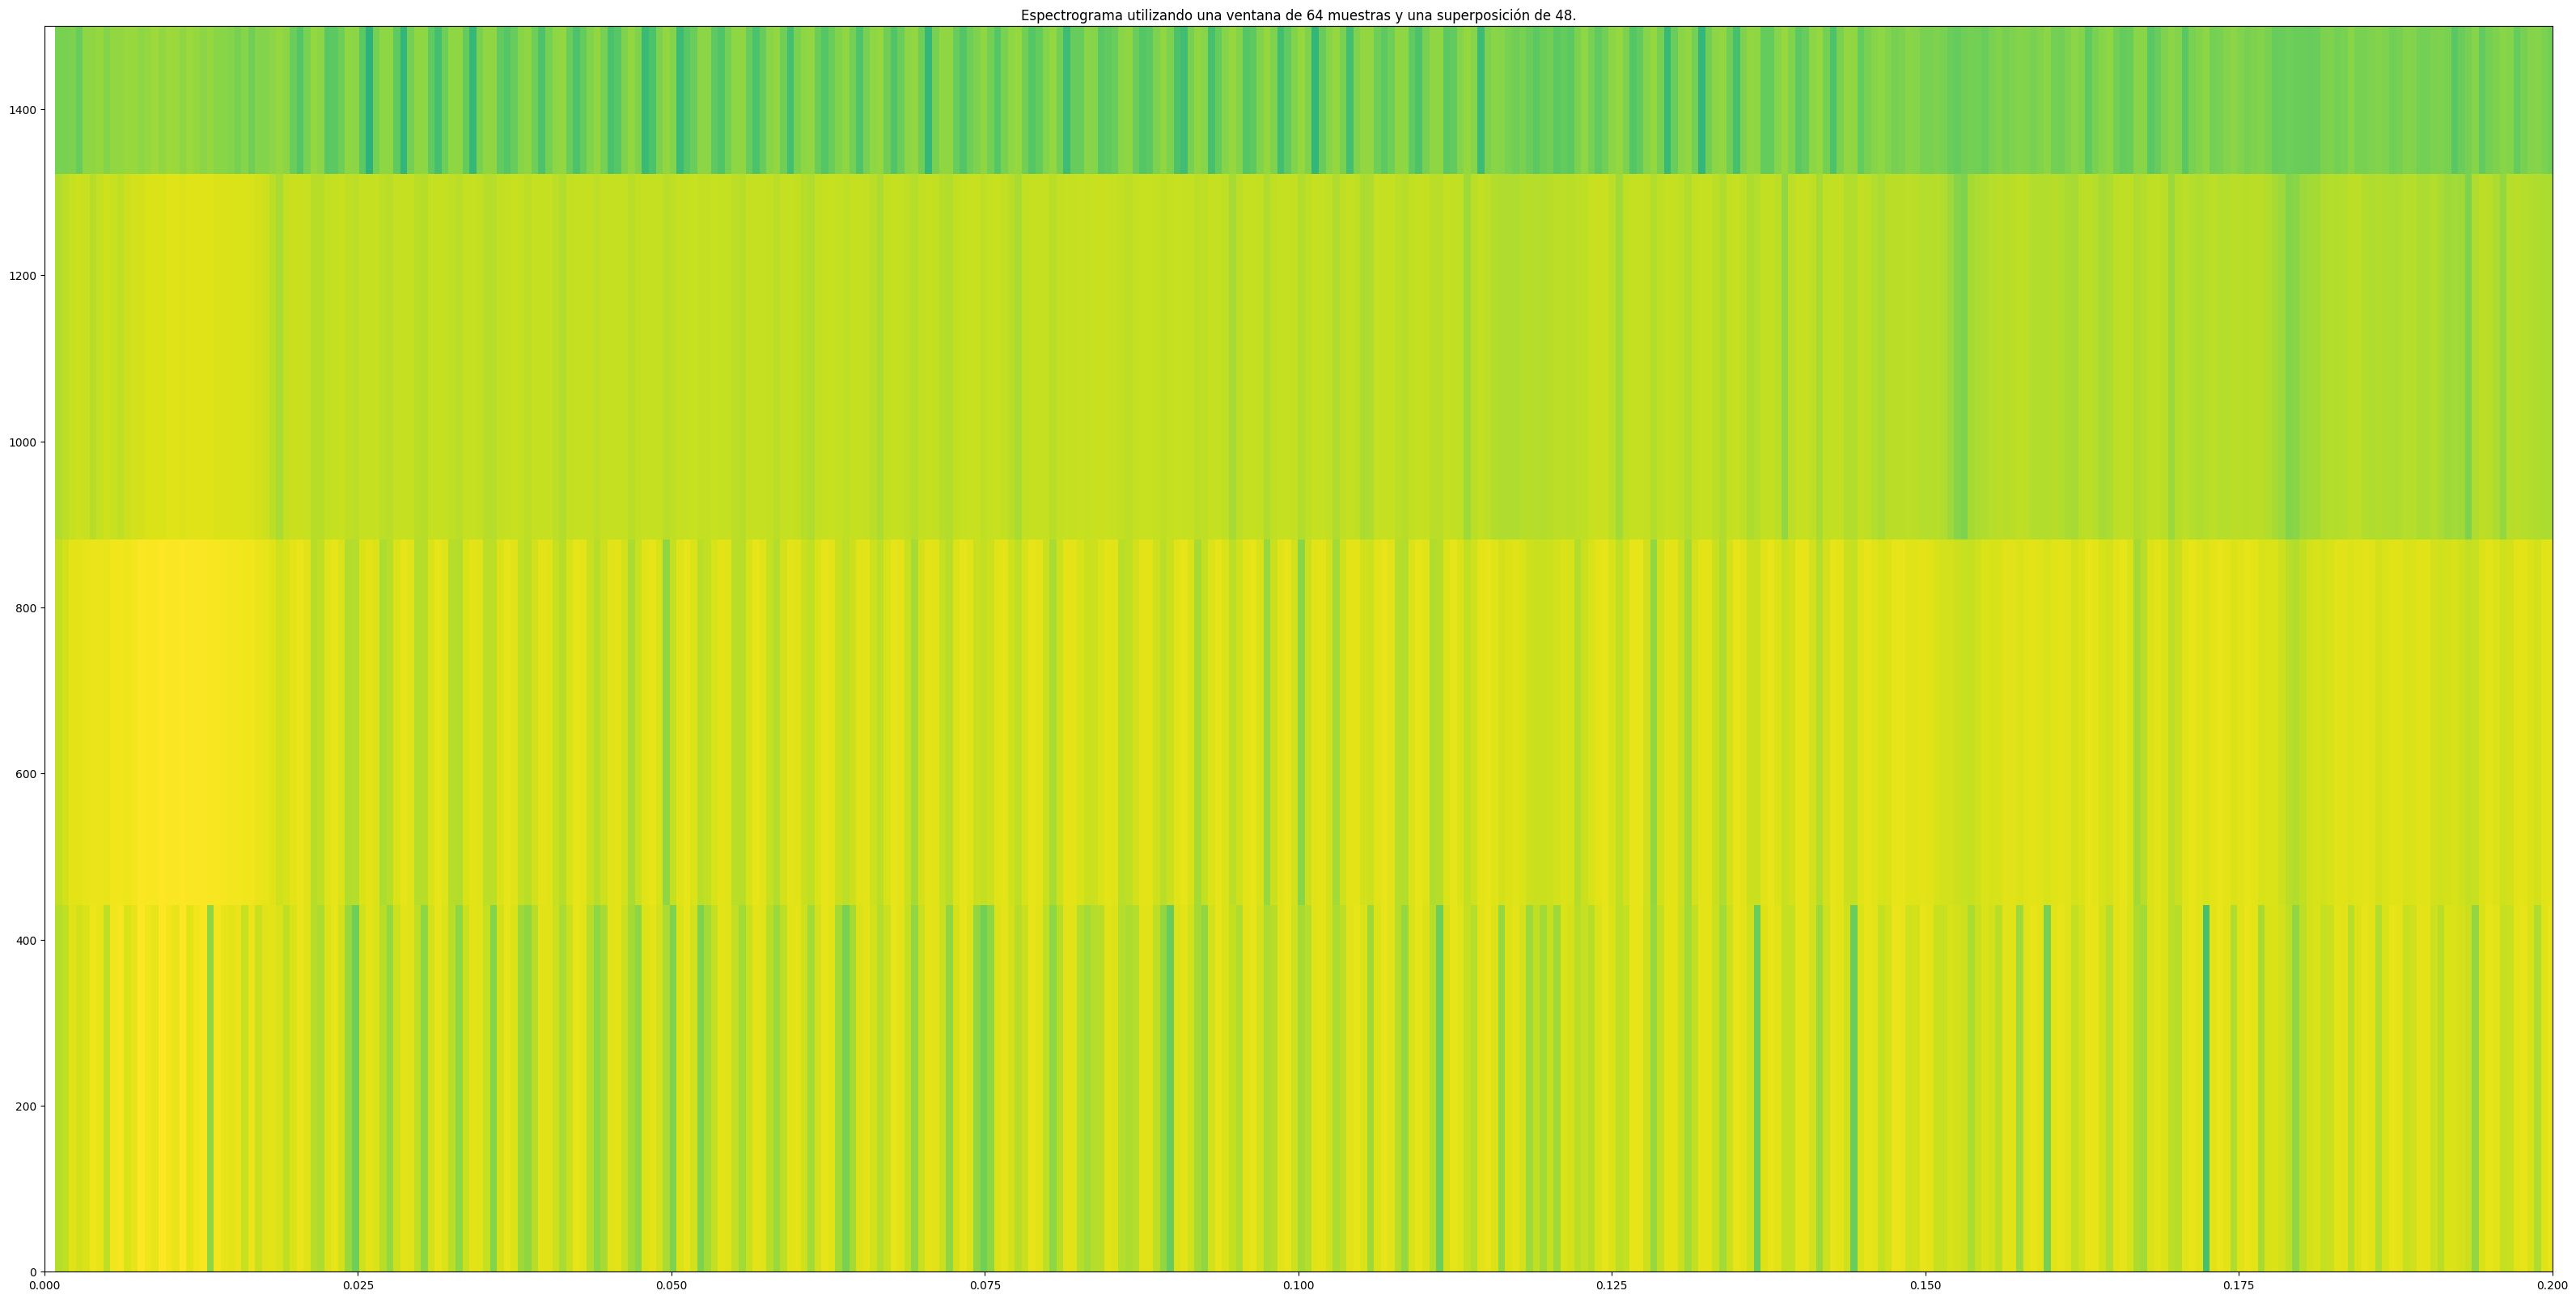

In [24]:
plot_specgram(final_values_filtered, 64, 48)

# Se repite el proceso usando el promedio de distintas ecometrías

In [25]:
id_equipo = 1
path = '_10_23_02_15_24__Frec1(301)_IncF(40)_Nciclos(5)_SwIn(1)_Down(32)_Nsamp)16000)'
full_path = f'../data/raw/ecometrias/{id_equipo}/{path}'

In [26]:
input_files = glob(full_path + '/*.json')

In [27]:
input_files

['../data/raw/ecometrias/1/_10_23_02_15_24__Frec1(301)_IncF(40)_Nciclos(5)_SwIn(1)_Down(32)_Nsamp)16000)/_Eco_02_42_17.json',
 '../data/raw/ecometrias/1/_10_23_02_15_24__Frec1(301)_IncF(40)_Nciclos(5)_SwIn(1)_Down(32)_Nsamp)16000)/_Eco_02_34_25.json',
 '../data/raw/ecometrias/1/_10_23_02_15_24__Frec1(301)_IncF(40)_Nciclos(5)_SwIn(1)_Down(32)_Nsamp)16000)/_Eco_02_20_53.json',
 '../data/raw/ecometrias/1/_10_23_02_15_24__Frec1(301)_IncF(40)_Nciclos(5)_SwIn(1)_Down(32)_Nsamp)16000)/_Eco_02_52_23.json',
 '../data/raw/ecometrias/1/_10_23_02_15_24__Frec1(301)_IncF(40)_Nciclos(5)_SwIn(1)_Down(32)_Nsamp)16000)/_Eco_02_48_12.json',
 '../data/raw/ecometrias/1/_10_23_02_15_24__Frec1(301)_IncF(40)_Nciclos(5)_SwIn(1)_Down(32)_Nsamp)16000)/_Eco_02_15_24.json']

In [28]:
files_values = []

for file in input_files:
    
    df, file_values = load_sample_file(file)
    
    files_values.append(file_values / np.max(np.abs(file_values)))

In [29]:
average_files_values_norm = np.average(files_values, axis=0)

In [30]:
final_signal_freq = 930000 / df.Down

In [31]:
nfft_w = widgets.IntText(
    value=32,
    description='NFFT:',
    disabled=False
)

noverlap_w = widgets.IntText(
    value=8,
    description='No overlap:',
    disabled=False
)

@interact_manual(nfft=nfft_w, noverlap=noverlap_w)
def plot_specgram(nfft, noverlap):
    fig, ax = plt.subplots(figsize=(20, 10))
    Pxx, freqs, bins, im = ax.specgram(average_files_values_norm,
                                       NFFT=nfft,
                                       Fs=final_signal_freq,
                                       noverlap=noverlap,
                                       cmap=plt.get_cmap('plasma'))

    plt.axis([0, 0.1, 0, 2000])

    plt.xlabel('Tiempo (segundos)')
    plt.ylabel('Frecuencia (Hz)')
    
    plt.title(f'Espectrograma utilizando una ventana de {nfft} muestras y una superposición de {noverlap} sobre el promedio de diferentes disparos.')
    plt.show()

interactive(children=(IntText(value=32, description='NFFT:'), IntText(value=8, description='No overlap:'), But…